# **PRAKTIKUM 1**

Langkah 1: Import Library dan Mount Google Drive

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Langkah 2: Load Dataset

In [ ]:
# Load images and labels from a directory structure
def load_dataset(img_dir):
    p = Path(img_dir)
    img_list = []
    for folder in p.glob('*'):
        label = folder.name
        for file in folder.glob('*.jpg'):
            img = cv2.imread(str(file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_list.append((img, label))
    return img_list

train_dir = "/content/drive/MyDrive/Colab Notebooks/Machine_Learning_25/dataset/JS15/images/training/"
test_dir  = "/content/drive/MyDrive/Colab Notebooks/Machine_Learning_25/dataset/JS15/images/test"

train_img = load_dataset(train_dir)
test_img  = load_dataset(test_dir)

print(f"Jumlah data training: {len(train_img)}")
print(f"Jumlah data testing: {len(test_img)}")

Jumlah data training: 240
Jumlah data testing: 160


Langkah 3: Preprocessing (Resize & Label Encoding)

In [ ]:
# Preprocess images: resize and encode labels
def resize_image(img, size=(256,256)):
    return cv2.resize(img, size)

def label_encoder(label):
    return 1 if label == 'day' else 0

def preprocess(img_list):
    X = []
    y = []
    for img, label in img_list:
        img_std = resize_image(img)
        X.append(img_std)
        y.append(label_encoder(label))
    return X, y

X_train_img, y_train = preprocess(train_img)
X_test_img,  y_test  = preprocess(test_img)

Langkah 4: Ekstraksi Fitur HOG (Histogram of Oriented Gradients)

In [ ]:
# Extract HOG features
def extract_hog(X_imgs):
    feats = []
    for img in X_imgs:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hog_feat = hog(gray,
                       orientations=9,
                       pixels_per_cell=(8,8),
                       cells_per_block=(2,2),
                       block_norm='L2-Hys',
                       visualize=False,
                       feature_vector=True)
        feats.append(hog_feat)
    return np.array(feats)

X_train_feat = extract_hog(X_train_img)
X_test_feat  = extract_hog(X_test_img)

Langkah 5: Normalisasi Fitur

In [ ]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_test_scaled  = scaler.transform(X_test_feat)

Langkah 6: Split Data Training & Validation

In [ ]:
# Split training data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_scaled, y_train,
    test_size=0.2,
    random_state=42
)

Langkah 7: Konversi Label ke Numpy Array

In [ ]:
# Convert labels to numpy arrays (required for Keras)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

Langkah 8: Membangun Arsitektur Model Neural Network

In [ ]:
# Build a simple feedforward neural network
# Define model architecture
# input_dim is the number of features in the dataset
# Hidden layer -> 128 neurons, ReLU activation
# Hidden layer -> 64 neurons, ReLU activation
# Output layer -> 1 neuron, Sigmoid activation (for binary classification)
input_dim = X_train.shape[1]

model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │     4,428,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,436,737 (16.92 MB)

 Trainable params: 4,436,737 (16.92 MB)

 Non-trainable params: 0 (0.00 B)

Langkah 9: Training Model

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.7116 - loss: 1.1334 - val_accuracy: 0.8958 - val_loss: 0.3547
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9985 - loss: 0.0295 - val_accuracy: 0.8958 - val_loss: 0.3160
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.8958 - val_loss: 0.4740
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 4.2479e-05 - val_accuracy: 0.9792 - val_loss: 0.2595
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 5.1578e-05 - val_accuracy: 0.9375 - val_loss: 0.2904
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 9.1365e-05 - val_accuracy: 0.9375 - val_loss: 0.3066
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 2.5571e-05 - val_accuracy: 0.9375 - val_loss: 0.3076
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 2.7783e-06 - val_accuracy: 0.937

Langkah 10: Evaluasi Model

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print("Akurasi Test:", test_acc)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9561 - loss: 0.5230
Akurasi Test: 0.9437500238418579


Langkah 11: Prediksi dan Laporan Klasifikasi serta Visualisasi

In [ ]:
# Generate classification report and confusion matrix
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
              precision    recall  f1-score   support

           0       0.92      0.97      0.95        80
           1       0.97      0.91      0.94        80

    accuracy                           0.94       160
   macro avg       0.95      0.94      0.94       160
weighted avg       0.95      0.94      0.94       160

[[78  2]
 [ 7 73]]


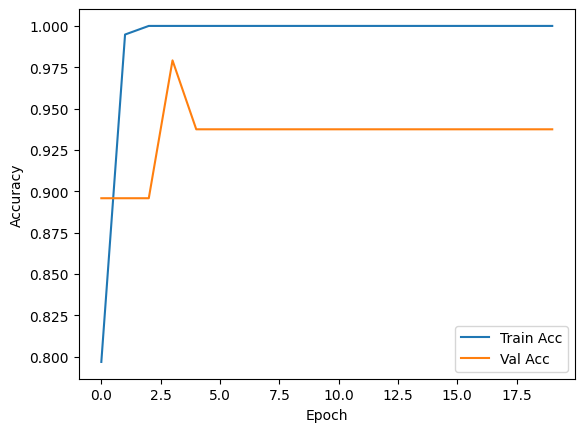

In [ ]:
# Visualize training history
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Langkah 12: Menyimpan Model dan Scaler

In [ ]:
# Save the trained model
import pickle

# 1. Simpan Model
# Menggunakan format .h5
model.save('day_night_model.h5')
print("✅ Model berhasil disimpan sebagai: day_night_model.h5")

# 2. Simpan Scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Scaler berhasil disimpan sebagai: scaler.pkl")

✅ Model berhasil disimpan sebagai: day_night_model.h5
✅ Scaler berhasil disimpan sebagai: scaler.pkl
